In [21]:
from hardwareModel import HardwareModel
import networkx as nx
import cvxpy as cp
import numpy as np
from netgraph import Graph
import matplotlib.pyplot as plt

In [22]:
hw = HardwareModel(cfg="aladdin_const_with_mem")

netlist: [('Add0', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 0}), ('Regs0', {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'size': 1, 'idx': 0}), ('Regs1', {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'size': 1, 'idx': 1}), ('Regs2', {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'size': 1, 'idx': 2}), ('Mult0', {'type': 'pe', 'function': 'Mult', 'in_use': 0, 'idx': 0}), ('Eq0', {'type': 'pe', 'function': 'Eq', 'in_use': 0, 'idx': 0}), ('Buf0', {'type': 'mem', 'function': 'Buf', 'in_use': 0, 'idx': 0, 'size': 22}), ('Buf1', {'type': 'mem', 'function': 'Buf', 'in_use': 0, 'idx': 1, 'size': 22}), ('Mem0', {'type': 'mem', 'function': 'MainMem', 'in_use': 0, 'idx': 0, 'size': 1024}), ('Regs3', {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'size': 1, 'idx': 3})]


In [23]:
print(hw.netlist)
print(hw.area)

DiGraph with 10 nodes and 38 edges
{'Add': 379348800.0, 'Sub': 379348800.0, 'And': 50369960.0, 'BitAnd': 50369960.0, 'BitOr': 50369960.0, 'BitXor': 50369960.0, 'Eq': 379348800.0, 'FloorDiv': 8340007000.0, 'Gt': 379348800.0, 'GtE': 379348800.0, 'Invert': 50369960.0, 'IsNot': 50369960.0, 'LShift': 24964610.0, 'Lt': 379348800.0, 'LtE': 379348800.0, 'Mod': 379348800.0, 'Mult': 8340007000.0, 'Not': 50369960.0, 'NotEq': 379348800.0, 'Or': 50369960.0, 'RShift': 24964610.0, 'Regs': 5981433.0, 'UAdd': 379348800.0, 'USub': 379348800.0, 'Buf': 0.0, 'MainMem': 5981433.0}


In [24]:
hw.area['Add']

379348800.0

In [25]:
newGraph = nx.DiGraph()
newGraph.add_nodes_from([(1, {'function' : 'Mult'}), (2, {'function' : 'Add'})])
newGraph.add_edges_from([(1, 2)])

In [26]:
#digraph = hw.netlist
digraph = newGraph
nodes = digraph.nodes
edges = digraph.edges
#print("Nodes:", list(nodes))
#print("Edges:", list(edges))
digraph.nodes.data(True)
#digraph.nodes.data['function']

NodeDataView({1: {'function': 'Mult'}, 2: {'function': 'Add'}})

In [27]:
def compute_Kij(i, j, n):
    # Create the unit vectors e_i and e_j
    e_i = np.zeros(n)
    e_j = np.zeros(n)
    e_i[i] = 1
    e_j[j] = 1
    
    # Compute the difference
    diff = e_i - e_j
    
    # Compute the outer product of the difference with itself
    Kij = np.outer(diff, diff)
    
    return Kij

In [28]:
print(nodes)

hw.area

[1, 2]


{'Add': 379348800.0,
 'Sub': 379348800.0,
 'And': 50369960.0,
 'BitAnd': 50369960.0,
 'BitOr': 50369960.0,
 'BitXor': 50369960.0,
 'Eq': 379348800.0,
 'FloorDiv': 8340007000.0,
 'Gt': 379348800.0,
 'GtE': 379348800.0,
 'Invert': 50369960.0,
 'IsNot': 50369960.0,
 'LShift': 24964610.0,
 'Lt': 379348800.0,
 'LtE': 379348800.0,
 'Mod': 379348800.0,
 'Mult': 8340007000.0,
 'Not': 50369960.0,
 'NotEq': 379348800.0,
 'Or': 50369960.0,
 'RShift': 24964610.0,
 'Regs': 5981433.0,
 'UAdd': 379348800.0,
 'USub': 379348800.0,
 'Buf': 0.0,
 'MainMem': 5981433.0}

In [29]:

node_to_index = {node: i for i, node in enumerate(nodes)}
#print(edges)
newEdges = []

for edge in edges:
    if (edge[1], edge[0]) in newEdges:
        continue

    newEdges.append(edge)

E = [(node_to_index[src], node_to_index[dst]) for src, dst in newEdges]
n = len(nodes)
w = np.asarray([[1.0] for _ in node_to_index])
areas = hw.area

for node in digraph.nodes.data(True):
    index = node_to_index[node[0]]
    w[index, 0] = areas[node[1]['function']]

diag_w = cp.diag(w)
wwT = w @ w.T
Ti = 100
di = 1
alpha = 1
Q = cp.Variable((n, n))
t = cp.Variable(n)

objective = cp.Maximize(cp.sum(cp.multiply(diag_w, Q))) 

constraints = [cp.sum(cp.multiply(wwT, Q)) == 0, Q >= 0] 

for i in range(n):
    #constraints += [t[i] <= i * (Ti / n)]
    constraints += [t[i] <= Ti]

#checkForDoubly = set()

for pair in E:
    #print(pair)
    first = pair[0]
    sec = pair[1]

    # if (pair[1], pair[0]) in checkForDoubly:
    #     continue

    # checkForDoubly.add(pair)
    constraints += [t[first] + di + alpha * cp.sum(cp.multiply(compute_Kij(first, sec, n), Q)) <= t[sec]]

prob = cp.Problem(objective, constraints)
prob.solve(solver='SCS', eps=1e-9, verbose=False)

print("The optimal value is", prob.value, '\n')
print("A solution t is", t.value, '\n')
print("A solution Q is", Q.value)

The optimal value is -6.7362513514084596e-18 

A solution t is [98.15776769 99.65254727] 

A solution Q is [[ 2.24038068e-29  1.21478289e-28]
 [ 1.21478289e-28 -1.82499569e-26]]


In [30]:
print(Q.value == Q.value.T)

[[ True  True]
 [ True  True]]


In [31]:
Q_matrix = Q.value

# for i in range(len(Q_matrix)):
#     for j in range(len(Q_matrix[0])):
#         if Q_matrix[i, j] < 0:
#             Q_matrix[i, j] = 0

#print(Q_matrix)

eigenvalues, eigenvectors = np.linalg.eigh(Q_matrix) 
print(eigenvalues)

# for i in range(len(eigenvalues)):
#     if eigenvalues[i] < 0:
#         eigenvalues[i] = 0

# D = np.diag(np.sqrt(eigenvalues))
# P = eigenvectors @ D

# print(Q.value)
# print('\n')
# print(P @ P.T)

[-1.82507645e-26  2.32113829e-29]


In [32]:
a1 = 1.0
a2 = 1.0
T = 100.0
di = 1.0
alpha = 1.0

t1 = cp.Variable()
t2 = cp.Variable()
Q = cp.Variable((2, 2))
#p = cp.Variable((2, 2))

#Q = p.T @ p
print(Q.shape)
q1 = Q[0, 0]
q2 = Q[0, 1]
q3 = Q[1, 0]
q4 = Q[1, 1]
KQ_inner_prod = q1 - 2 * q2 + q4
wwT_Q = q1 * (a1 ** 2) + q2 * a1 * a2 + q3 * a1 * a2 + q4 * (a2 ** 2)



# q1 = x1 ** 2 + y1 ** 2
# q4 = x2 ** 2 + y2 ** 2
# q2 = -( (a1 ** 2) * q1 + (a2 ** 2) * q4 ) / (2 * a1 * a2)

print(Q)
objective = cp.Maximize(a1 * q1 + a2 * q4)

constraints = [t1 + di + alpha * KQ_inner_prod <= t2, Q >= 0, t1 <= T, t2 <= T, wwT_Q == 0]

prob = cp.Problem(objective, constraints)
prob.solve(solver='SCS', verbose=False)
print(prob.value, '\n')
print(Q.value)
print('\n')

eigenvalues, eigenvectors = np.linalg.eigh(Q.value) 
print(eigenvalues)

(2, 2)
var292
5.683264772838868e-07 

[[ 2.84163239e-07 -4.54562813e-07]
 [-1.13551245e-07  2.84163239e-07]]


[1.70611994e-07 3.97714483e-07]


In [33]:
print(Q.value == Q.value.T)

[[ True False]
 [False  True]]


In [34]:
print(node_to_index)

{1: 0, 2: 1}


In [60]:
KQ_inner = cp.sum(cp.multiply(compute_Kij(0, 1, 2), Q.value))
lengths = []

for edge in newEdges:
    first = edge[0]
    sec = edge[1]
    length = np.sum(np.multiply(compute_Kij(node_to_index[first], node_to_index[sec], len(node_to_index)), Q.value)) ** 0.5
    lengths = (first, sec, length)
    #newGraph[first][sec]['weight'] = length

print(lengths)

(1, 2, 0.0010660396496853)


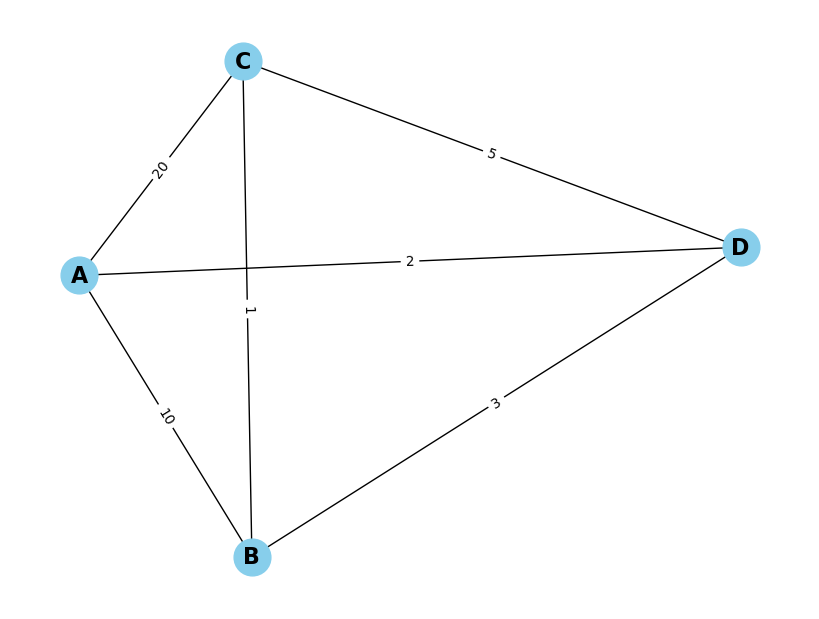

In [61]:
G = nx.Graph()
# G.add_edge('A', 'B', weight=10)
# G.add_edge('B', 'C', weight=1)
# G.add_edge('C', 'D', weight=5)
# G.add_edge('D', 'A', weight=2)
# G.add_edge('A', 'C', weight=20)
# G.add_edge('B', 'D', weight=3)

edges_with_weights = [
    ('A', 'B', 10),
    ('B', 'C', 1),
    ('C', 'D', 5),
    ('D', 'A', 2),
    ('A', 'C', 20),
    ('B', 'D', 3)
]
G.add_weighted_edges_from(edges_with_weights)
pos = nx.spring_layout(G, weight='weight', iterations=1000, k=0.5/np.sqrt(len(G.nodes())))
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_weight='bold', font_size=16)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

In [62]:
def plotter(G, edges_with_weights):
    G.add_weighted_edges_from(edges_with_weights)
    pos = nx.spring_layout(G, weight='weight', iterations=1000, k=0.5/np.sqrt(len(G.nodes())))
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_weight='bold', font_size=16)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()

In [63]:
plotter(newGraph, lengths)

TypeError: cannot unpack non-iterable int object